# Prelim

Dataset downloaded from : https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_unsorted_10k


Data is available at `s3://fh-pi-setty-m-eco-public/single-cell-primers/multiome/`
Review the notebook `PBMC-RNA-standalone.ipynb` for setup instructions.

## Load data

Download all the multiome data using the following command

In [1]:
#!aws s3 sync s3://fh-pi-setty-m-eco-public/single-cell-primers/multiome/ ../data/multiome/

# Imports

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
import scanpy as sc
import pyranges as pr
import warnings

In [4]:
import palantir 
import phenograph
import harmony

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [7]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [8]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc

def _dot_func(x, y):
    return x.dot(y)


def impute_data(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # RUn in parallel
    seq = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])
    res = Parallel(n_jobs=-1)(delayed(_dot_func)(T_steps, ad.X[:, seq[i - 1]:seq[i]]) for i in range(1, len(seq)))
    imputed_data = hstack(res)
    imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return imputed_data

# Load data

In [9]:
data_dir = '../data/multiome/' #change to your data dir 

In [10]:
data_dir = '/fh/fast/setty_m/grp/public-datasets/10x_pbmc_10k_multiome/'

In [11]:
# Load 10x filtered matrix containing both RNA and ATAC features 
comb_ad = sc.read_10x_h5(data_dir + 'pbmc_unsorted_10k_filtered_feature_bc_matrix.h5', gex_only=False)
comb_ad.obs_names = 'pbmc_multiome#' + comb_ad.obs_names

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
comb_ad

AnnData object with n_obs × n_vars = 12016 × 100352
    var: 'gene_ids', 'feature_types', 'genome'


Add the features.tsv to the Anndata to allow matching of gene names to ENSEMBL IDs.

In [13]:
comb_ad.uns['features'] = pd.read_csv(data_dir + "filtered_feature_bc_matrix/features.tsv.gz")

In [14]:
# Barcode metrics
bc_metrics = pd.read_csv(data_dir + '/pbmc_unsorted_10k_per_barcode_metrics.csv', 
                index_col=0)
bc_metrics.index = 'pbmc_multiome' + '#' +bc_metrics.index 

# FRIP
bc_metrics['FRIP'] = bc_metrics['atac_peak_region_fragments']/bc_metrics['atac_fragments']

In [15]:
# Separate RNA and ATAC components
rna_ad = comb_ad[:, comb_ad.var['feature_types'] == 'Gene Expression']
rna_ad.var_names_make_unique()

atac_ad = comb_ad[:, comb_ad.var['feature_types'] == 'Peaks']
atac_ad.var_names_make_unique()

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
rna_ad

AnnData object with n_obs × n_vars = 12016 × 36601
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'features'

In [17]:
atac_ad

AnnData object with n_obs × n_vars = 12016 × 63751
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'features'

In [18]:
sample_cells = rna_ad.obs_names

# Preprocess

This section follows the preprocessing steps of the single-cell RNA-seq analysis 

In [19]:
ad = rna_ad

## QC

In [20]:
ad.var['mt'] = ad.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True, percent_top=None, log1p=False, )

### Filter cell based on RNA

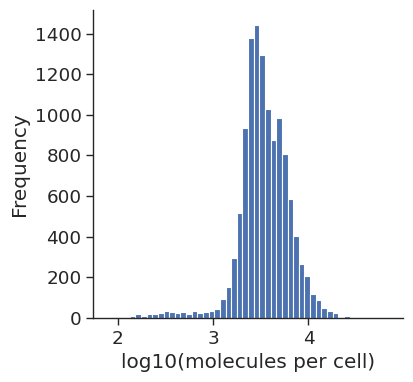

In [21]:
plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs['total_counts']), 50)
ax.set_xlabel('log10(molecules per cell)')
ax.set_ylabel('Frequency')
sns.despine()

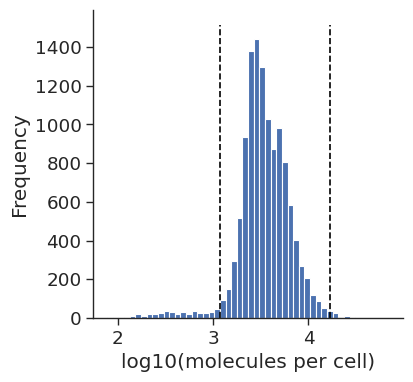

In [22]:
# Manually adjust the threshold percentage depending on the dataset
# Doublet detection (Eg: scrublet) will work better for higher molecule count cells
THRESHOLDS = np.log10(np.percentile((ad.obs['total_counts']), [3.5, 99.5]))

plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs['total_counts']), 50)
ax.vlines(THRESHOLDS, ax.get_ylim()[0], ax.get_ylim()[1], color='black', linestyle='--')
ax.set_xlabel('log10(molecules per cell)')
ax.set_ylabel('Frequency')
sns.despine()

In [23]:
# Filter cells 
sample_cells = sample_cells[(np.log10(ad.obs['total_counts'][sample_cells]) > THRESHOLDS[0]) & \
    (np.log10(ad.obs['total_counts'][sample_cells]) < THRESHOLDS[1]) ]


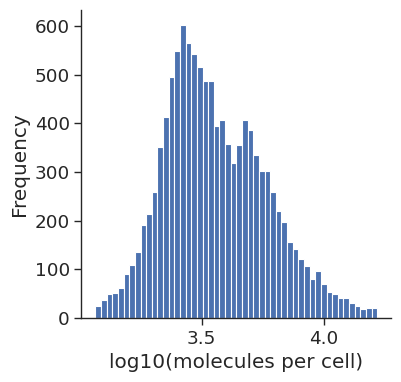

In [24]:
plt.figure()
ax = plt.gca()
ax.hist(np.log10(ad.obs['total_counts'][sample_cells]), 50)
ax.set_xlabel('log10(molecules per cell)')
ax.set_ylabel('Frequency')
sns.despine()

### Filter based on ATAC

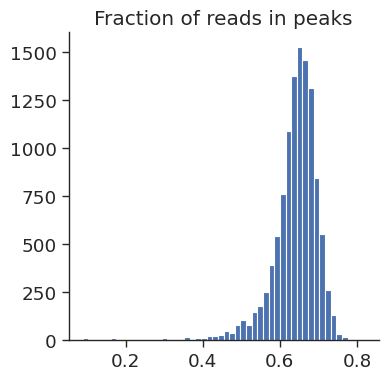

In [25]:
## CAUTION: CellRanger peak calling is unreliable and we only use it here to filter cells with low 
##          fraction of reads in peaks. This is ok since CellRanger peak caller dramatically over estimates 
##          the peak widths. We might incur some false negatives, but thats an acceptable error for filtering   
plt.figure()
ax = plt.gca()
ax.hist(bc_metrics['FRIP'][sample_cells], 50)
plt.title('Fraction of reads in peaks')
sns.despine()

In [26]:
THRESHOLD = 0.4
sample_cells = sample_cells[bc_metrics['FRIP'][sample_cells] > THRESHOLD]

### Filter based on mitochondria

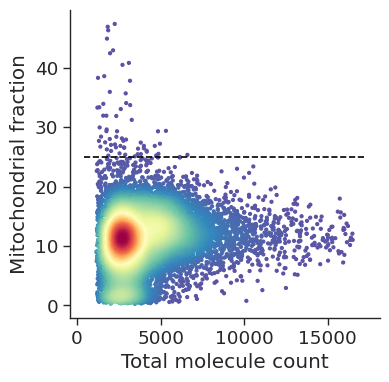

In [27]:
MITO_THRESHOLD = 25

x,y,dens = palantir.plot.density_2d(ad.obs['total_counts'][sample_cells], 
               ad.obs['pct_counts_mt'][sample_cells])

plt.figure()
ax = plt.gca()
ax.scatter(x, y, c=dens, s=5)
ax.hlines(MITO_THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], color='black', linestyle='--')

plt.xlabel('Total molecule count')
plt.ylabel('Mitochondrial fraction')
sns.despine()


In [28]:
sample_cells = sample_cells[ad.obs['pct_counts_mt'][sample_cells] < MITO_THRESHOLD]

In [29]:
ad = ad[sample_cells, :]
ad

View of AnnData object with n_obs × n_vars = 11275 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'features'

## Analysis

In [30]:
# Filter genes 
sc.pp.filter_genes(ad, min_cells=50)

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [31]:
# Normalize and log transform
sc.pp.normalize_per_cell(ad)
log_transform(ad)

In [32]:
# Highly variable genes [Num. of genes is a paramter, typically 1.5-2.5k genes work well]
sc.pp.highly_variable_genes(ad, flavor='cell_ranger', n_top_genes=2500)
ad

AnnData object with n_obs × n_vars = 11275 × 16426
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'features', 'hvg'

In [33]:
# PCA
sc.pp.pca(ad, use_highly_variable=True, n_comps=50)
ad
# 50 comps is an approxmiation here - choose number of components by knee point or fraction of explained variance

AnnData object with n_obs × n_vars = 11275 × 16426
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'features', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [34]:
# UMAP and Leiden - requires the computation of nearest neighbors
sc.pp.neighbors(ad, use_rep='X_pca')
sc.tl.umap(ad)
sc.tl.leiden(ad)
ad

2023-01-25 17:03:22.178285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 17:03:22.333535: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-25 17:03:22.338271: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-25 17:03:22.338294: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

AnnData object with n_obs × n_vars = 11275 × 16426
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'features', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [35]:
# Diffusion maps 
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_pca'], index=ad.obs_names))
ad.obsp['DM_Kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors'] = dm_res['EigenVectors'].values
ad.uns['DMEigenValues'] = dm_res['EigenValues'].values
ad

Determing nearest neighbor graph...


AnnData object with n_obs × n_vars = 11275 × 16426
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'features', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'DMEigenValues'
    obsm: 'X_pca', 'X_umap', 'DM_EigenVectors'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'DM_Kernel'

In [36]:
# Phenograph 
ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_pca'])
ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 3.239081621170044 seconds
Jaccard graph constructed in 2.4175174236297607 seconds
Wrote graph to binary file in 0.21897292137145996 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.880247
Louvain completed 21 runs in 6.39564847946167 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 14.044792652130127 seconds


In [37]:
# Imputation

ad.obsm['MAGIC_imputed_data'] = np.array(impute_data(dm_res, ad))
ad.layers['MAGIC_imputed_data'] = ad.obsm['MAGIC_imputed_data']

# Visualize results

In [38]:
ad.obs['log_n_counts'] = np.log10(ad.obs['total_counts'])

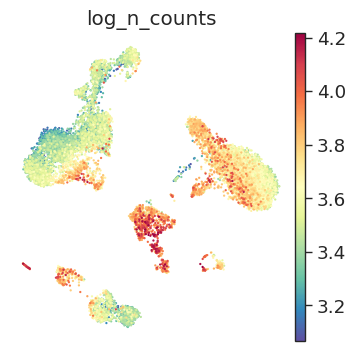

In [39]:
sc.pl.embedding(ad, basis='umap', color='log_n_counts', frameon=False)

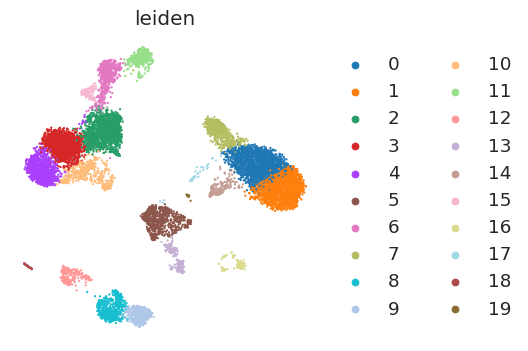

In [40]:
sc.pl.embedding(ad, basis='umap', color=['leiden'], frameon=False)

# Celltype annotation

In [41]:
genes = pd.Series([
    "CD34",  #Early Progenitor
    "GATA1", #Erythroid
    "PAX5", "MS4A1", "MME", #B-Cell Trajectory
    "CD14",  #Monocytes
    "CD3D", "CD8A", 'CD4', #TCells,
    'FCGR3A', #'CD16', 
     'LEF1', 'NKG7', 'TREM1', 'LYZ', 'CD19',  'IRF8', 'IRF4',
    'ITGA2B', # CD41,
    'NCAM1', # CD56,
    'CCR7' # Memory T cell
])
genes = genes[genes.isin(ad.var_names)]

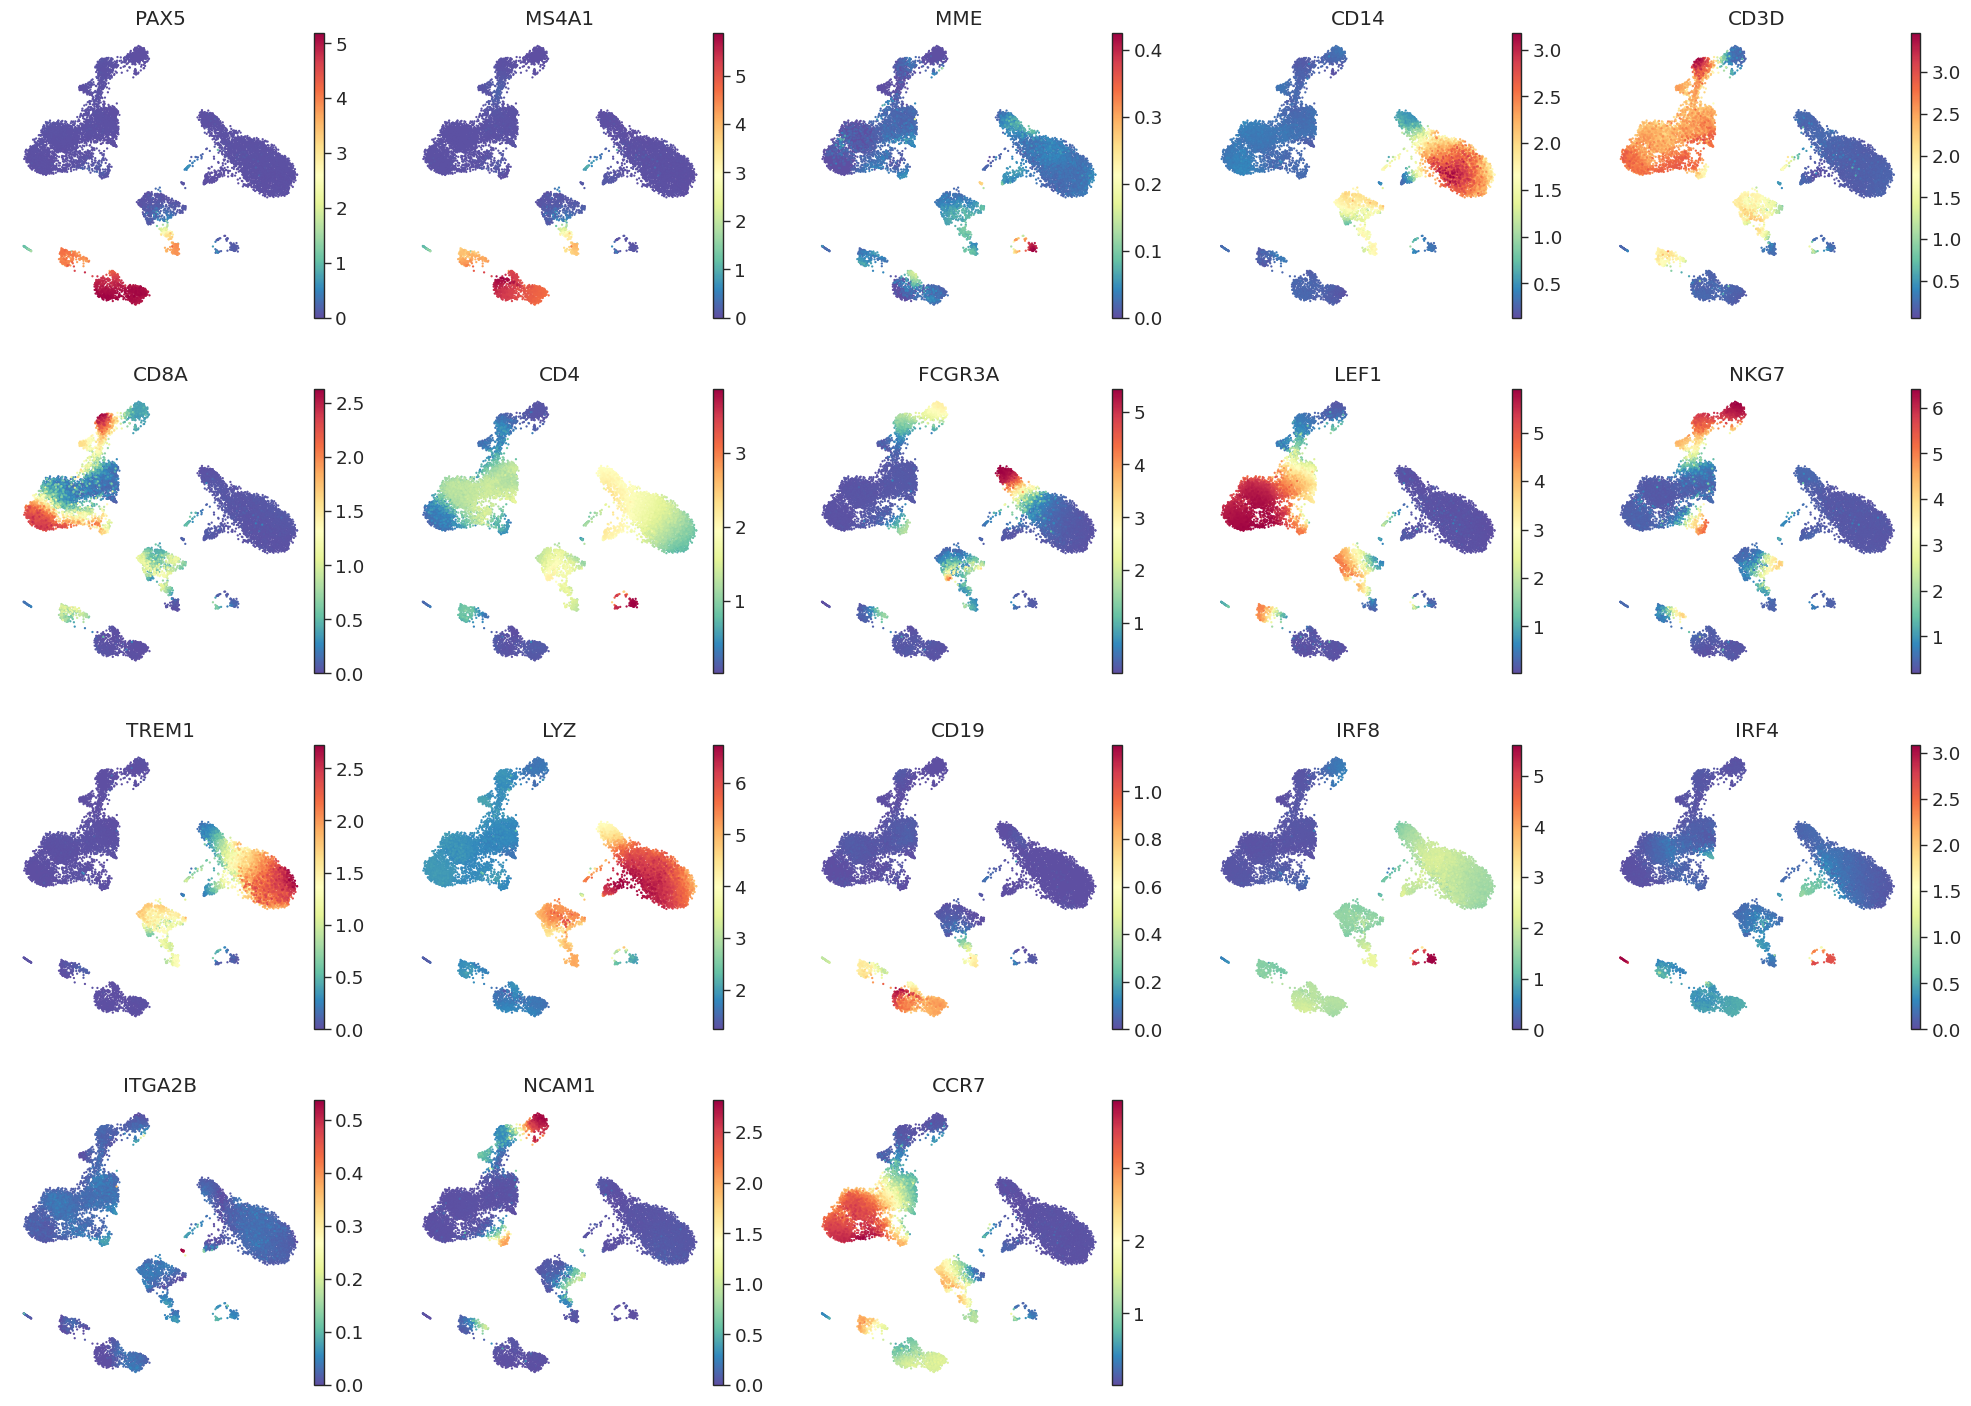

In [42]:
sc.pl.embedding(ad, basis='umap', color=genes, layer='MAGIC_imputed_data', frameon=False, ncols=5)

Cell type annotation can be performed using the same markers listed in https://github.com/settylab/single-cell-primers/blob/main/notebooks/PBMC-RNA-standalone.ipynb

# Save

In [43]:
temp = comb_ad[ad.obs_names, :]
temp.var_names_make_unique()
temp = temp[:, ad.var_names]

/home/cjordan2/.conda/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [44]:
# Attach raw counts
ad.raw = sc.AnnData(temp.X)

In [45]:
from scipy.sparse import csr_matrix
ad.layers['MAGIC_imputed_data'] = csr_matrix(ad.layers['MAGIC_imputed_data'])

In [46]:
ad.write(data_dir + 'pbmc_multiome_rna.h5ad')

In [47]:
# Export cell names for ATAC - only this subset of cells will be use for ATAC analysis
pd.DataFrame(ad.obs_names.str.split('#').str.get(1)).to_csv(data_dir + 'pbmc_multiome_cells.csv')

In [48]:
!head $data_dir/pbmc_multiome_cells.csv

,0
0,AAACAGCCAAAGCCTC-1
1,AAACAGCCAGAATGAC-1
2,AAACAGCCAGCTACGT-1
3,AAACAGCCAGGCCTTG-1
4,AAACAGCCATAATGTC-1
5,AAACATGCAGCAATAA-1
6,AAACATGCAGCCAGAA-1
7,AAACATGCAGGCGATA-1
8,AAACATGCAGTTTCTC-1
